# **La capa física como autocodificador**
Un autocodificador es un tipo de red neuronal artificial que se utiliza para encontrar una representación útil de algunos datos en una capa intermedia x aprendiendo a reproducir la entrada en la salida.

<img src="https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder_0.png?raw=true" alt="Drawing" style="width: 400px;"/>

##Inicialización
**Primero: cambie el tiempo de ejecución y la aceleración de hardware**

Ejecución → Cambiar tipo de ejecución

- Programa de ejecución: Python 3
- Acelerador de hardware: GPU

In [ ]:
#Instale TensorFlow 2.0 en Google Collab si es necesario
try:
  # %tensorflow_version solo existe en Colab.
  %tensorflow_version 2.x
except Exception:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.8.2
Number of GPUs available : 1
Only GPU number 0 used


In [7]:
import numpy as np
import matplotlib.pyplot as plt  

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax

In [ ]:
SEED = 1

##Modulación
Recuerde la modulación: el objetivo es encontrar un buen conjunto de símbolos para enviar a través de un canal.

Si queremos enviar 3 bits, necesitamos tener **8 símbolos**:
![Modulación](https://github.com/mgoutay/ml_course/blob/master/Images/AWGN.png?raw=true)

La constelación (aquí 8-PSK) necesita ser robusta al canal (aquí canal AWGN).

¡Lo que queremos es encontrar una constelación mejor!

## Comunicar mensajes
**Un sistema de comunicación basado en autocodificador tiene como objetivo implementar el transmisor, el canal y el receptor como un solo NN que reconstruye su entrada en su salida**.

El objetivo es aprender una modulación que sea robusta con respecto a las perturbaciones introducidas por el canal.

El canal se implementa como una "capa de ruido" sin ningún parámetro aprendible, que debe ser diferenciable para realizar SGD en los parámetros del transmisor.

Ejemplos:

- Canal AWGN: y=x+n

- ...

![autoencoder](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder.png?raw=true)

**Transmitamos mensajes**.

El primer hiperparámetro a configurar es el número total de símbolos (o mensajes) $M$. En nuestro problema simple, el número de usos del canal $Nc$ se establece en 1.

Se puede ver que $M$ también se puede ver como el orden de modulación. De hecho, enviar uno de $M$ símbolos (mensaje) es equivalente a enviar $\log_2(M)$ bits.

Implementaremos la siguiente red:

<img src="https://github.com/mgoutay/ml_course/blob/master/Images/autoencoder.png?raw=true" alt="Drawing" style="width: 700px;"/>

1. Cada mensaje $m$ se convierte primero a su representación one_hot. Si tenemos el tercer mensaje de 8, la representación one_hot será $[0,0,1,0,0,0,0,0]$
2. Ese vector one_hot se le da a la primera capa densa.
3. La última capa densa del transmisor generará $2$ números reales por símbolo.
4. Serán normalizados para tener una energía promedio de $1$ por la capa de normalización.
5. Luego, la capa $\mathbb{R}2\mathbb{C}$ convertirá esos $2$ números en 1 número complejo, que se enviará por el canal. Esos son los símbolos transmitidos x .
6. El canal agregará algo de ruido gaussiano aleatorio (canal AWGN).
7. La capa $\mathbb{C}2\mathbb{R}$ convierte el número complejo en $2$ números reales, que se le dan a la primera capa densa. Esto es obligatorio ya que Tensorflow no tiene capas densas complejas. La última capa densa tiene salida $M$ (el número de símbolos diferentes).
8. La salida de la última capa densa se entrega a la capa softmax. Para un $y$ recibido dado, genera probabilidades $\mathbf{p}_m=[p(m=0|y),p(m=1|y),...,p(m=M|y)]$ de que se haya enviado cada símbolo. Esas probabilidades son útiles durante el entrenamiento.
- De hecho, esta es una tarea típica de clasificación. Queremos predecir a qué "clase" (qué símbolo) pertenece la señal recibida $y$. La pérdida habitual para la tarea de clasificación es la entropía cruzada categórica, que "compara" la clase verdadera ($m$) con las probabilidades predichas $\mathbf{p}_m$.
9. Tomamos el símbolo con mayor probabilidad de haber sido enviado con la capa $\text{argmax}$. Este es $\hat{m}$.

## Definir las capas

In [ ]:
class Normalization(Layer):

    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, symbols):        
        # Normalizar la potencia por símbolo a 1
        en_moy = tf.sqrt(2 * tf.reduce_mean(tf.square(symbols)))
        symbols_norm = tf.divide(symbols, en_moy)
        
        return symbols_norm

In [ ]:
class R2C(Layer):

    def __init__(self, **kwargs):
        super(R2C, self).__init__(**kwargs)

    def call(self, x):
        # Convierte 2Nc números reales en Nc números complejos
        x_cplx = tf.complex(x[:, :1], x[:, 1:])
            
        return x_cplx

In [ ]:
class C2R(Layer):

    def __init__(self, **kwargs):
        super(C2R, self).__init__(**kwargs)

    def call(self, y):
        #convierte Nc números complejos en 2Nc números reales
        y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
            
        return y_real

In [ ]:
class OneHot(Layer):

    def __init__(self, M, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.M = M

    def call(self, msg):
        
        one_hot_msg = tf.one_hot(msg, depth = M)
        
        return one_hot_msg

In [ ]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)
            
    def call(self, x, snr):
        # Agrega ruido gaussiano aleatorio a la entrada
        noise_stddev = tf.sqrt( 2 / tf.pow(10., snr/10.0))
        noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_cplx = tf.complex(noise_r, noise_i, name="noise")

        y = x + noise_cplx

        return y

## Generar mensajes

In [1]:
def generate_ds_msg(epoch_len, batch_size, M):
    
    #Generar un conjunto de datos de lotes de mensajes 'epoch_len'. Cada lote
    #tiene un tamaño 'batch_size' y consta de mensajes (símbolos) entre 0 y M-1
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    features_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    
    #Las etiquetas son las mismas que las funciones: este es un codificador
    #automático, queremos predecir el mismo mensaje que se ha enviado.
    labels_ds = features_ds
    
    return (features_ds, labels_ds)

## Define the model

In [ ]:
class Autoencoder(Model):

    def __init__(self, M, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        #Establecer los atributos de la clase
        self.M = M

        #Inicializar las capas del transmisor
        self.oh = OneHot(self.M)
        self.d1 = Dense(64, activation='elu')
        self.d2 = Dense(2, activation=None)
        self.norm = Normalization()
        self.r2c = R2C()
        
        #Inicializar el canal
        self.ch = Channel()
        
        #Inicializar las capas del receptor
        self.c2r = C2R()
        self.d3 = Dense(64, activation='elu')
        self.d4 = Dense(self.M, activation=None)
        self.softm = Softmax()
    
    def call(self, inputs, snr):
        
        # Transmisor
        self.x1 = self.oh(inputs)
        self.x2 = self.d1(self.x1)
        self.x3 = self.d2(self.x2)
        self.x4 = self.norm(self.x3)
        self.x = self.r2c(self.x4)
    
        #Canal
        self.y = self.ch(self.x, snr)
        
        #Receptor
        self.pb1 = self.c2r(self.y)
        self.pb2 = self.d3(self.pb1)
        self.pb3 = self.d4(self.pb2)
        self.pb = self.softm(self.pb3)
    
        return self.pb

## ¿Qué pasa con la función de pérdida?
La función de pérdida es la **entropía cruzada categórica** (solo hay una clase buena) **escasa**:

In [ ]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Crear una instancia del codificador automático

In [ ]:
# Numero de mensajes
M = 8

In [6]:
#Establecer las semillas
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Crear el codificador automático
autoencoder = Autoencoder(M)

NameError: ignored

# See constellation before training

In [4]:
snr_eval = 10

#Forme un lote que contenga todos los mensajes.
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)

NameError: ignored

In [3]:
batch_msg.shape

NameError: ignored

# Train

In [ ]:
batch_size = 10000
epoch_size = 100
nb_epoch = 25
snr_training = 15

print('Symbol Error Rate after each epoch:')

#Inicializar optimizador
optimizer = tf.keras.optimizers.Adam()

for epoch in range(nb_epoch):
    
    #Crear un conjunto de datos aleatorio para cada época
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M))

    #Iterar sobre los lotes del conjunto de datos.
    for step, (features, labels) in enumerate(dataset):
        # Abrir una GradientTape.
        with tf.GradientTape() as tape:

            #Paso hacia adelante.
            probas = autoencoder(features, snr_training)

            #Valor de pérdida para este lote.
            loss_value =  loss_func(y_true=labels, y_pred=probas)

        #Obtenga gradientes de pérdida con respecto a los pesos.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        #Actualice los pesos de nuestra capa lineal.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Tome el argmax de la distribución de probabilidad como el mensaje estimado
    m_hat = tf.argmax(probas, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')
print('Hecho')

Symbol Error Rate after each epoch:
0.2302, 0.0468, 0.014, 0.01, 0.0111, 0.0109, 0.0107, 0.011, 0.0105, 0.009, 0.0102, 0.0094, 0.0102, 0.0091, 0.0107, 0.0111, 0.0097, 0.0098, 0.0112, 0.0094, 0.009, 0.0113, 0.0097, 0.0106, 0.009, Done


## Evaluate the model

In [ ]:
snr_range = np.arange(-5, 21)
results=[]
bs_eval = 100000

for snr_eval in snr_range:
    
    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)
    
    p_m = autoencoder(batch_msg, snr_eval)
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(snr_eval, end=', ')
    results.append(ser.numpy())

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

In [ ]:
PSK8 = np.array([0.77506, 0.765, 0.74813, 0.7275, 0.70289, 0.68373, 0.65119, 0.62056, 0.58119, 0.54035, 0.49605, 0.44836, 0.39359, 0.34086, 0.28307, 0.22817, 0.17711, 0.12972, 0.09176, 0.05412, 0.03235, 0.01594, 0.0068, 0.00256, 0.00071, 0.00015])

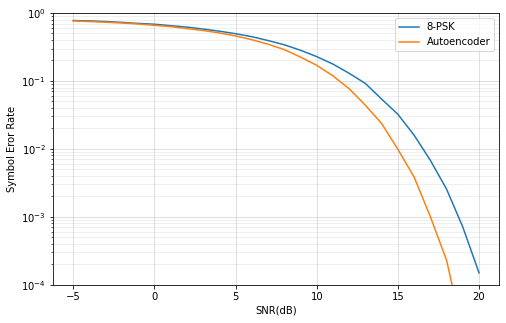

In [ ]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, PSK8, label='8-PSK')
plt.semilogy(snr_range, results, label='Autoencoder')
plt.legend()
plt.xlabel('SNR(dB)')
plt.ylabel('Symbol Eror Rate');
plt.ylim(1e-4, 1)
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## Ver constelación aprendida

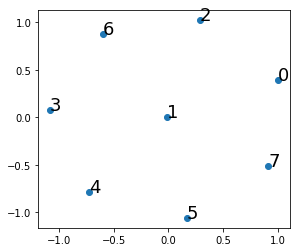

In [ ]:
snr_eval = 10

# Formar un lote que contenga todos los mensajes.
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)